# Klasifikasi Emosi

Muhammad Ghifari Zuhir

Kelas = [Marah, Sedih, Senang]

In [ ]:
import os
import glob
import argparse

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import  confusion_matrix


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dir = '/content/drive/MyDrive/Dicoding/deployment/Dataset'

In [ ]:
train = list(glob.glob(f'{train_dir}/*/*'))

In [ ]:
print('jumlah data train : ', len(train))

jumlah data train :  2468


In [ ]:
a = np.random.randint(2468, size=10)

In [ ]:
ex_img = []
for i in a:
  img = mpimg.imread(train[i])
  ex_img.append(img)

In [ ]:
for i in ex_img:
  print(i.shape)

(229, 229, 3)
(213, 213, 3)
(199, 199, 3)
(195, 195, 3)
(207, 207, 3)
(216, 216, 3)
(217, 217, 3)
(205, 205, 3)
(218, 218, 3)
(219, 219, 3)


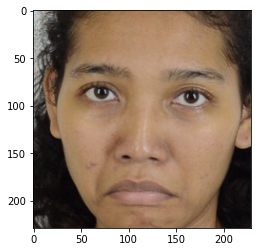

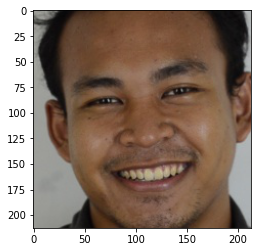

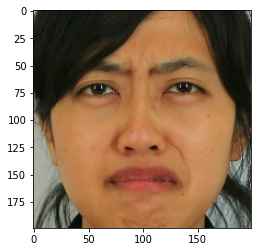

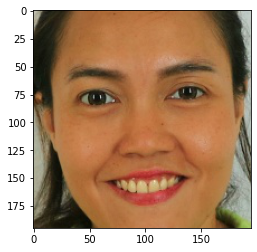

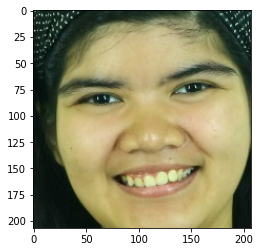

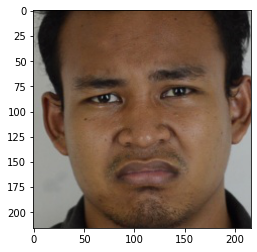

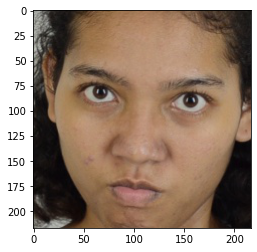

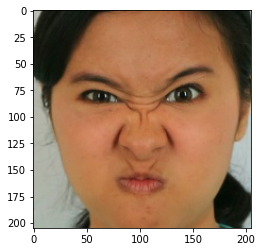

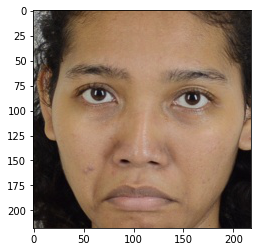

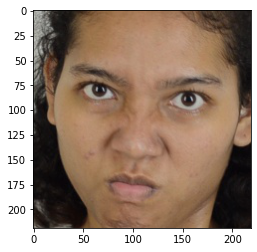

In [ ]:
for ima in ex_img:
    plt.figure()
    plt.imshow(ima)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255, 
                             validation_split = 0.2,
                             rotation_range = 20,
                             horizontal_flip = True,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             fill_mode = "nearest")

In [ ]:
img_size = 224
batch_size = 128
 
train_generator = datagen.flow_from_directory(train_dir,
                                              target_size=(img_size, img_size),
                                              batch_size=batch_size,
                                              class_mode="categorical",
                                              subset='training')

val_generator = datagen.flow_from_directory(train_dir,
                                            target_size=(img_size, img_size),
                                            batch_size=batch_size,
                                            class_mode="categorical",
                                            subset='validation')

Found 1975 images belonging to 3 classes.
Found 493 images belonging to 3 classes.


In [ ]:
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
model = tf.keras.Sequential([base_model,
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(rate=0.2),
                             tf.keras.layers.Dense(3, activation='softmax')])

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)

model.compile(opt,
              loss= "categorical_crossentropy",
              metrics= ["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 1539      
Total params: 27,561,795
Trainable params: 12,847,107
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history = model.fit(train_generator,
                    epochs = 300,
                    callbacks = [es],
                    validation_data = val_generator)

Epoch 1/300
16/16 [==============================] - 827s 49s/step - loss: 0.8281 - accuracy: 0.6339 - val_loss: 0.6662 - val_accuracy: 0.6126
Epoch 2/300
16/16 [==============================] - 32s 2s/step - loss: 0.2955 - accuracy: 0.8977 - val_loss: 0.4102 - val_accuracy: 0.8296
Epoch 3/300
16/16 [==============================] - 33s 2s/step - loss: 0.1719 - accuracy: 0.9575 - val_loss: 0.4105 - val_accuracy: 0.8154
Epoch 4/300
16/16 [==============================] - 31s 2s/step - loss: 0.1096 - accuracy: 0.9818 - val_loss: 0.2991 - val_accuracy: 0.8742
Epoch 5/300
16/16 [==============================] - 33s 2s/step - loss: 0.0804 - accuracy: 0.9873 - val_loss: 0.2916 - val_accuracy: 0.8722
Epoch 6/300
16/16 [==============================] - 31s 2s/step - loss: 0.0656 - accuracy: 0.9889 - val_loss: 0.2566 - val_accuracy: 0.8803
Epoch 7/300
16/16 [==============================] - 33s 2s/step - loss: 0.0516 - accuracy: 0.9934 - val_loss: 0.3661 - val_accuracy: 0.8479
Epoch 8/300

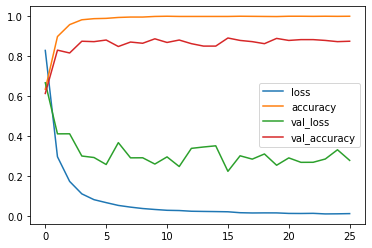

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpunkdxfgi/assets
